In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
from scipy.stats import ks_2samp
import tensorflow as tf

### Data Exploration and Observations

In [4]:
original_data = pd.read_csv('../data/original_data.csv')
original_data.shape

(50000, 2)

In [5]:
original_data['effort'] = original_data['effort'].astype('category')
original_data['effort'].cat.categories.sort_values()

Index(['(-0.001, 0.000309]', '(0.000309, 0.00134]', '(0.00134, 0.00214]',
       '(0.00214, 0.00287]', '(0.00287, 0.00367]', '(0.00367, 0.00468]',
       '(0.00468, 0.00649]', '(0.00649, 0.04]', '(0.04, 12.67]',
       '(12.67, 3296.64]'],
      dtype='object')

In [6]:
effort_bands = original_data['effort'].unique().sort_values()
original_data['effort'].cat.set_categories(effort_bands, ordered = True)

0           (0.00649, 0.04]
1        (0.00134, 0.00214]
2        (0.00287, 0.00367]
3        (-0.001, 0.000309]
4        (0.00134, 0.00214]
                ...        
49995         (0.04, 12.67]
49996    (0.00367, 0.00468]
49997       (0.00649, 0.04]
49998    (0.00214, 0.00287]
49999       (0.00649, 0.04]
Name: effort, Length: 50000, dtype: category
Categories (10, object): ['(-0.001, 0.000309]' < '(0.000309, 0.00134]' < '(0.00134, 0.00214]' < '(0.00214, 0.00287]' ... '(0.00468, 0.00649]' < '(0.00649, 0.04]' < '(0.04, 12.67]' < '(12.67, 3296.64]']

The categories are ordinal as shown above and 
this need to be taken in to consideration.

In [7]:
original_data.groupby('effort').count()

,MonthlyIncome
effort,
"(-0.001, 0.000309]",5585
"(0.000309, 0.00134]",6228
"(0.00134, 0.00214]",6147
"(0.00214, 0.00287]",6196
"(0.00287, 0.00367]",6197
"(0.00367, 0.00468]",6283
"(0.00468, 0.00649]",6303
"(0.00649, 0.04]",6023
"(0.04, 12.67]",668


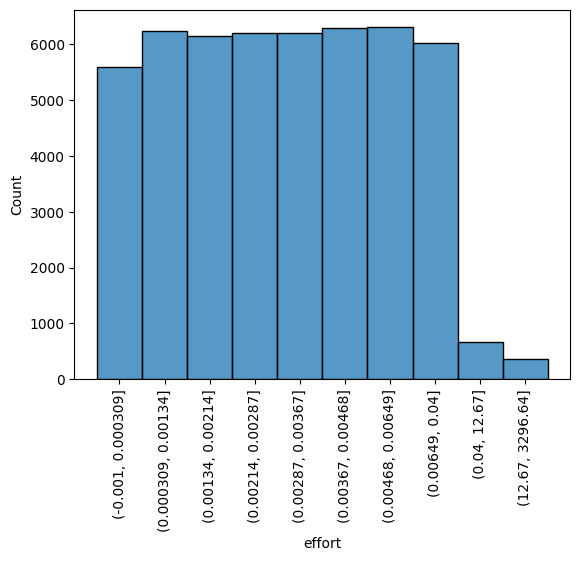

In [8]:
plot = sns.histplot(data=original_data,  x="effort")
_ = plt.setp(plot.get_xticklabels(), rotation=90)

Graph above shows, classes are imbalanced and this needs to be taken in to consideration.

In [9]:
original_data.groupby('effort').agg([min,max])

MonthlyIncome           
                              min        max
effort                                      
(-0.001, 0.000309]            0.0  3008750.0
(0.000309, 0.00134]         100.0   304000.0
(0.00134, 0.00214]            5.0   100000.0
(0.00214, 0.00287]          100.0    63333.0
(0.00287, 0.00367]          179.0    75000.0
(0.00367, 0.00468]          135.0    58000.0
(0.00468, 0.00649]            1.0    48374.0
(0.00649, 0.04]               0.0    33333.0
(0.04, 12.67]                 0.0    25800.0
(12.67, 3296.64]              0.0        1.0

There are some outliers in the data shown in the above table.

In [10]:
original_data[original_data['MonthlyIncome'] == 0].groupby('effort').count()


,MonthlyIncome
effort,
"(-0.001, 0.000309]",46
"(0.000309, 0.00134]",0
"(0.00134, 0.00214]",0
"(0.00214, 0.00287]",0
"(0.00287, 0.00367]",0
"(0.00367, 0.00468]",0
"(0.00468, 0.00649]",0
"(0.00649, 0.04]",18
"(0.04, 12.67]",356


In [11]:
original_data[original_data['MonthlyIncome'] == 1].groupby('effort').count()

,MonthlyIncome
effort,
"(-0.001, 0.000309]",25
"(0.000309, 0.00134]",0
"(0.00134, 0.00214]",0
"(0.00214, 0.00287]",0
"(0.00287, 0.00367]",0
"(0.00367, 0.00468]",0
"(0.00468, 0.00649]",3
"(0.00649, 0.04]",6
"(0.04, 12.67]",139


(0.04, 12.67] and (12.67, 3296.64] are magarety zeroes and ones and that needs to be taken in to consideration in the model.

In [12]:
original_data[(original_data['MonthlyIncome'] > 1)].groupby('effort').count()

,MonthlyIncome
effort,
"(-0.001, 0.000309]",5514
"(0.000309, 0.00134]",6228
"(0.00134, 0.00214]",6147
"(0.00214, 0.00287]",6196
"(0.00287, 0.00367]",6197
"(0.00367, 0.00468]",6283
"(0.00468, 0.00649]",6300
"(0.00649, 0.04]",5999
"(0.04, 12.67]",173


Below we look at disteributions in each category, in log scale and excluding zeros.
Disterbutions seem to be skewed and vary in each category. 

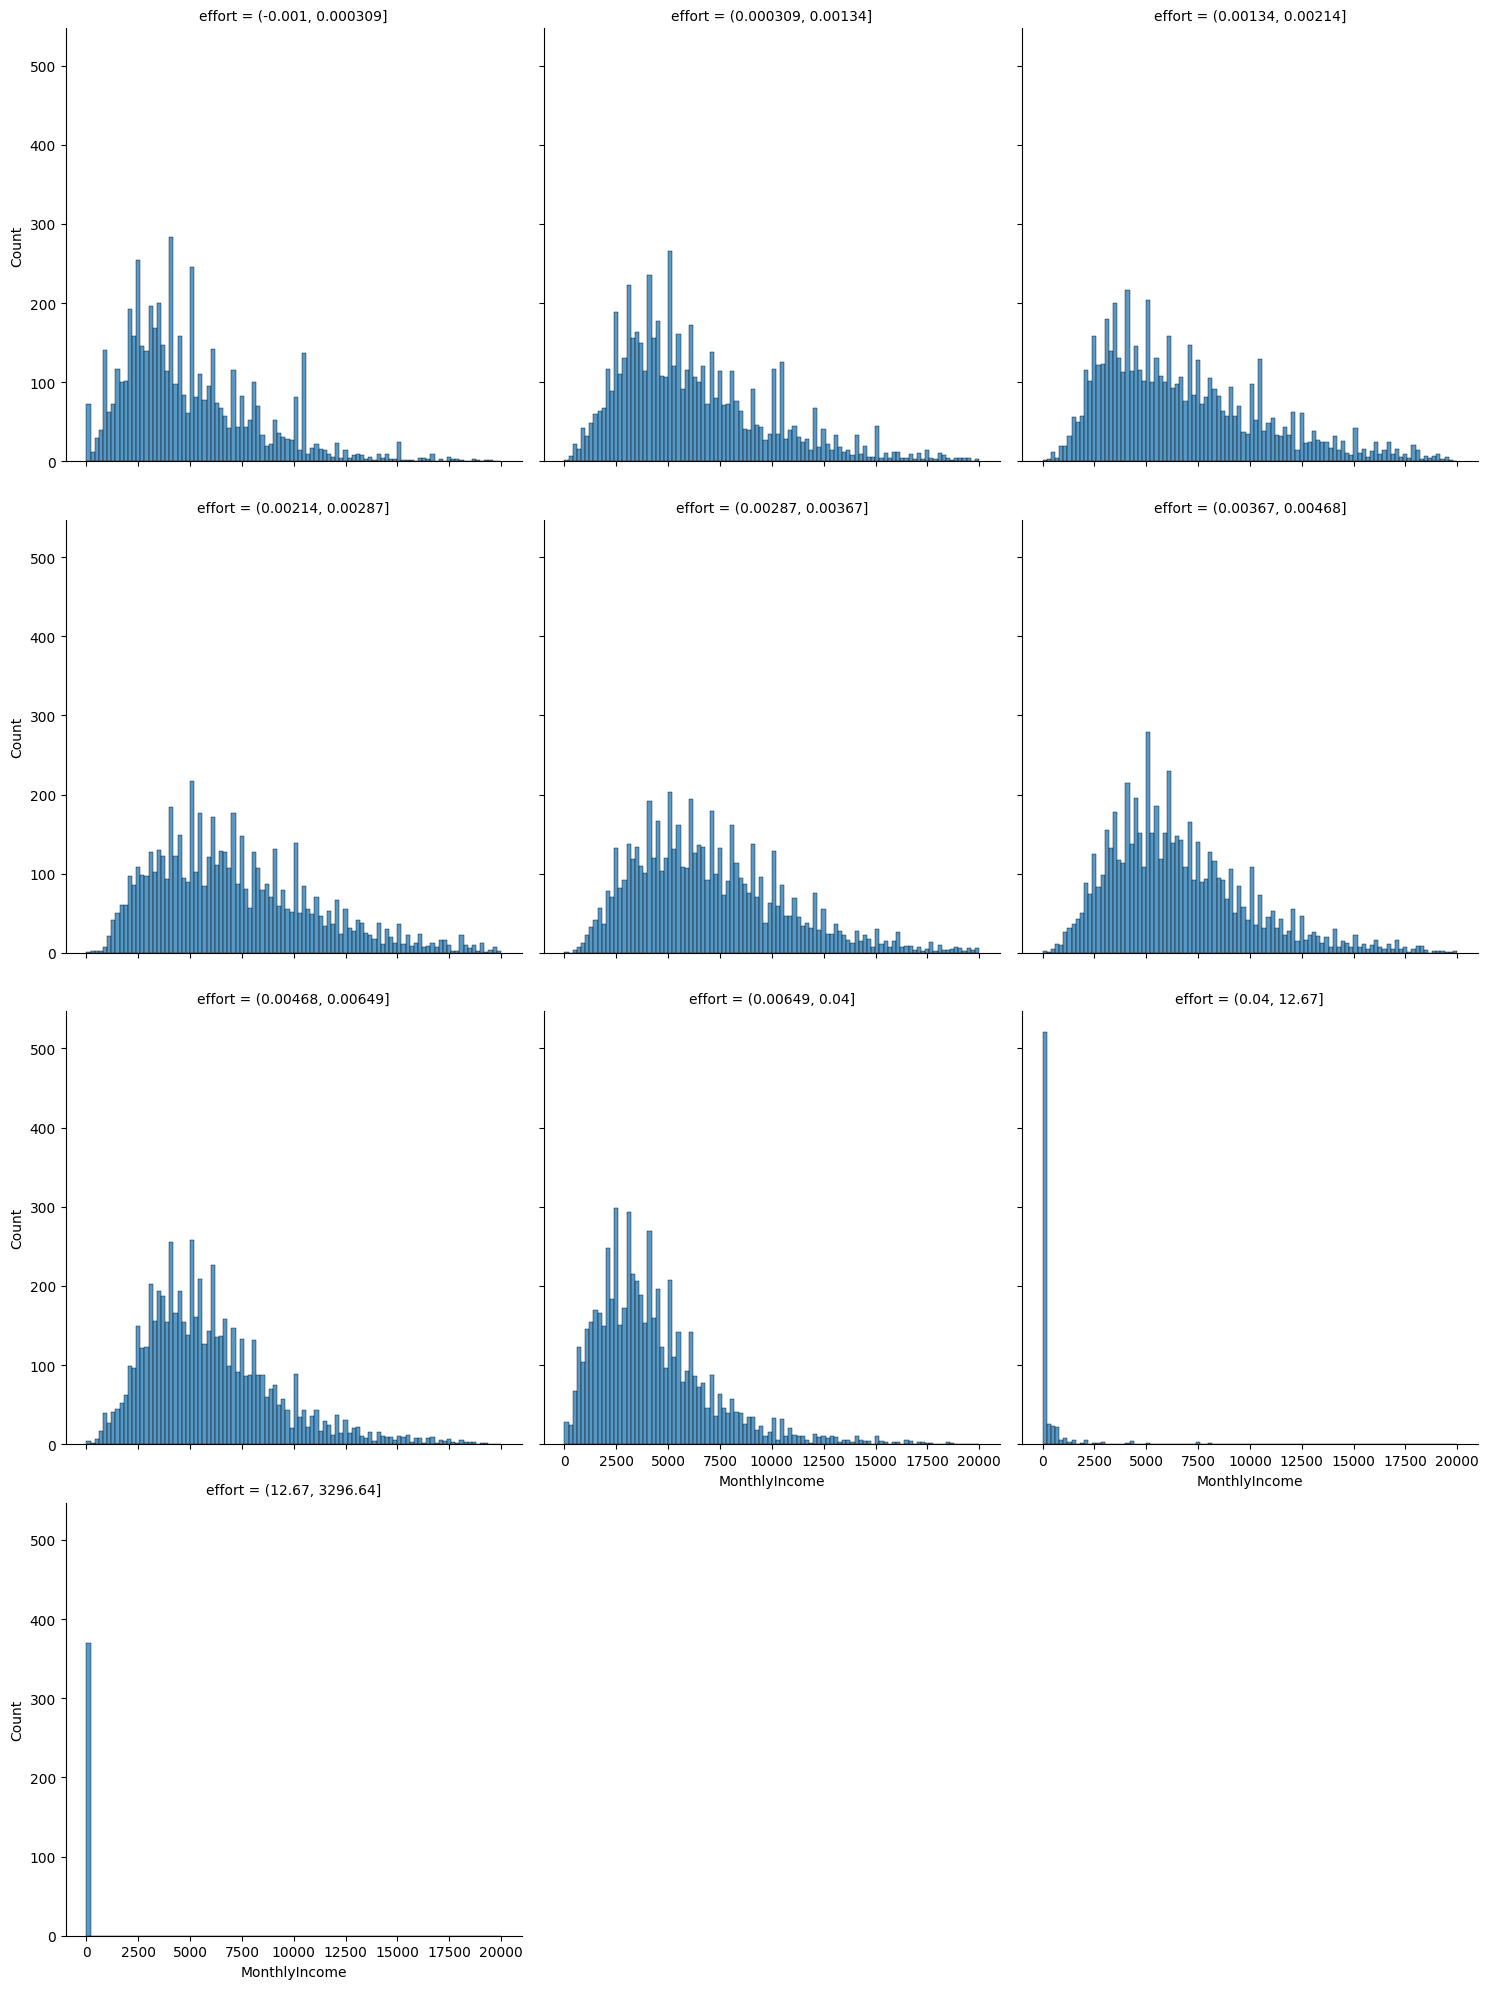

In [13]:

sns.displot(data =original_data[original_data['MonthlyIncome'] < 20000], x = 'MonthlyIncome', col = 'effort', col_wrap = 3, bins = 100)



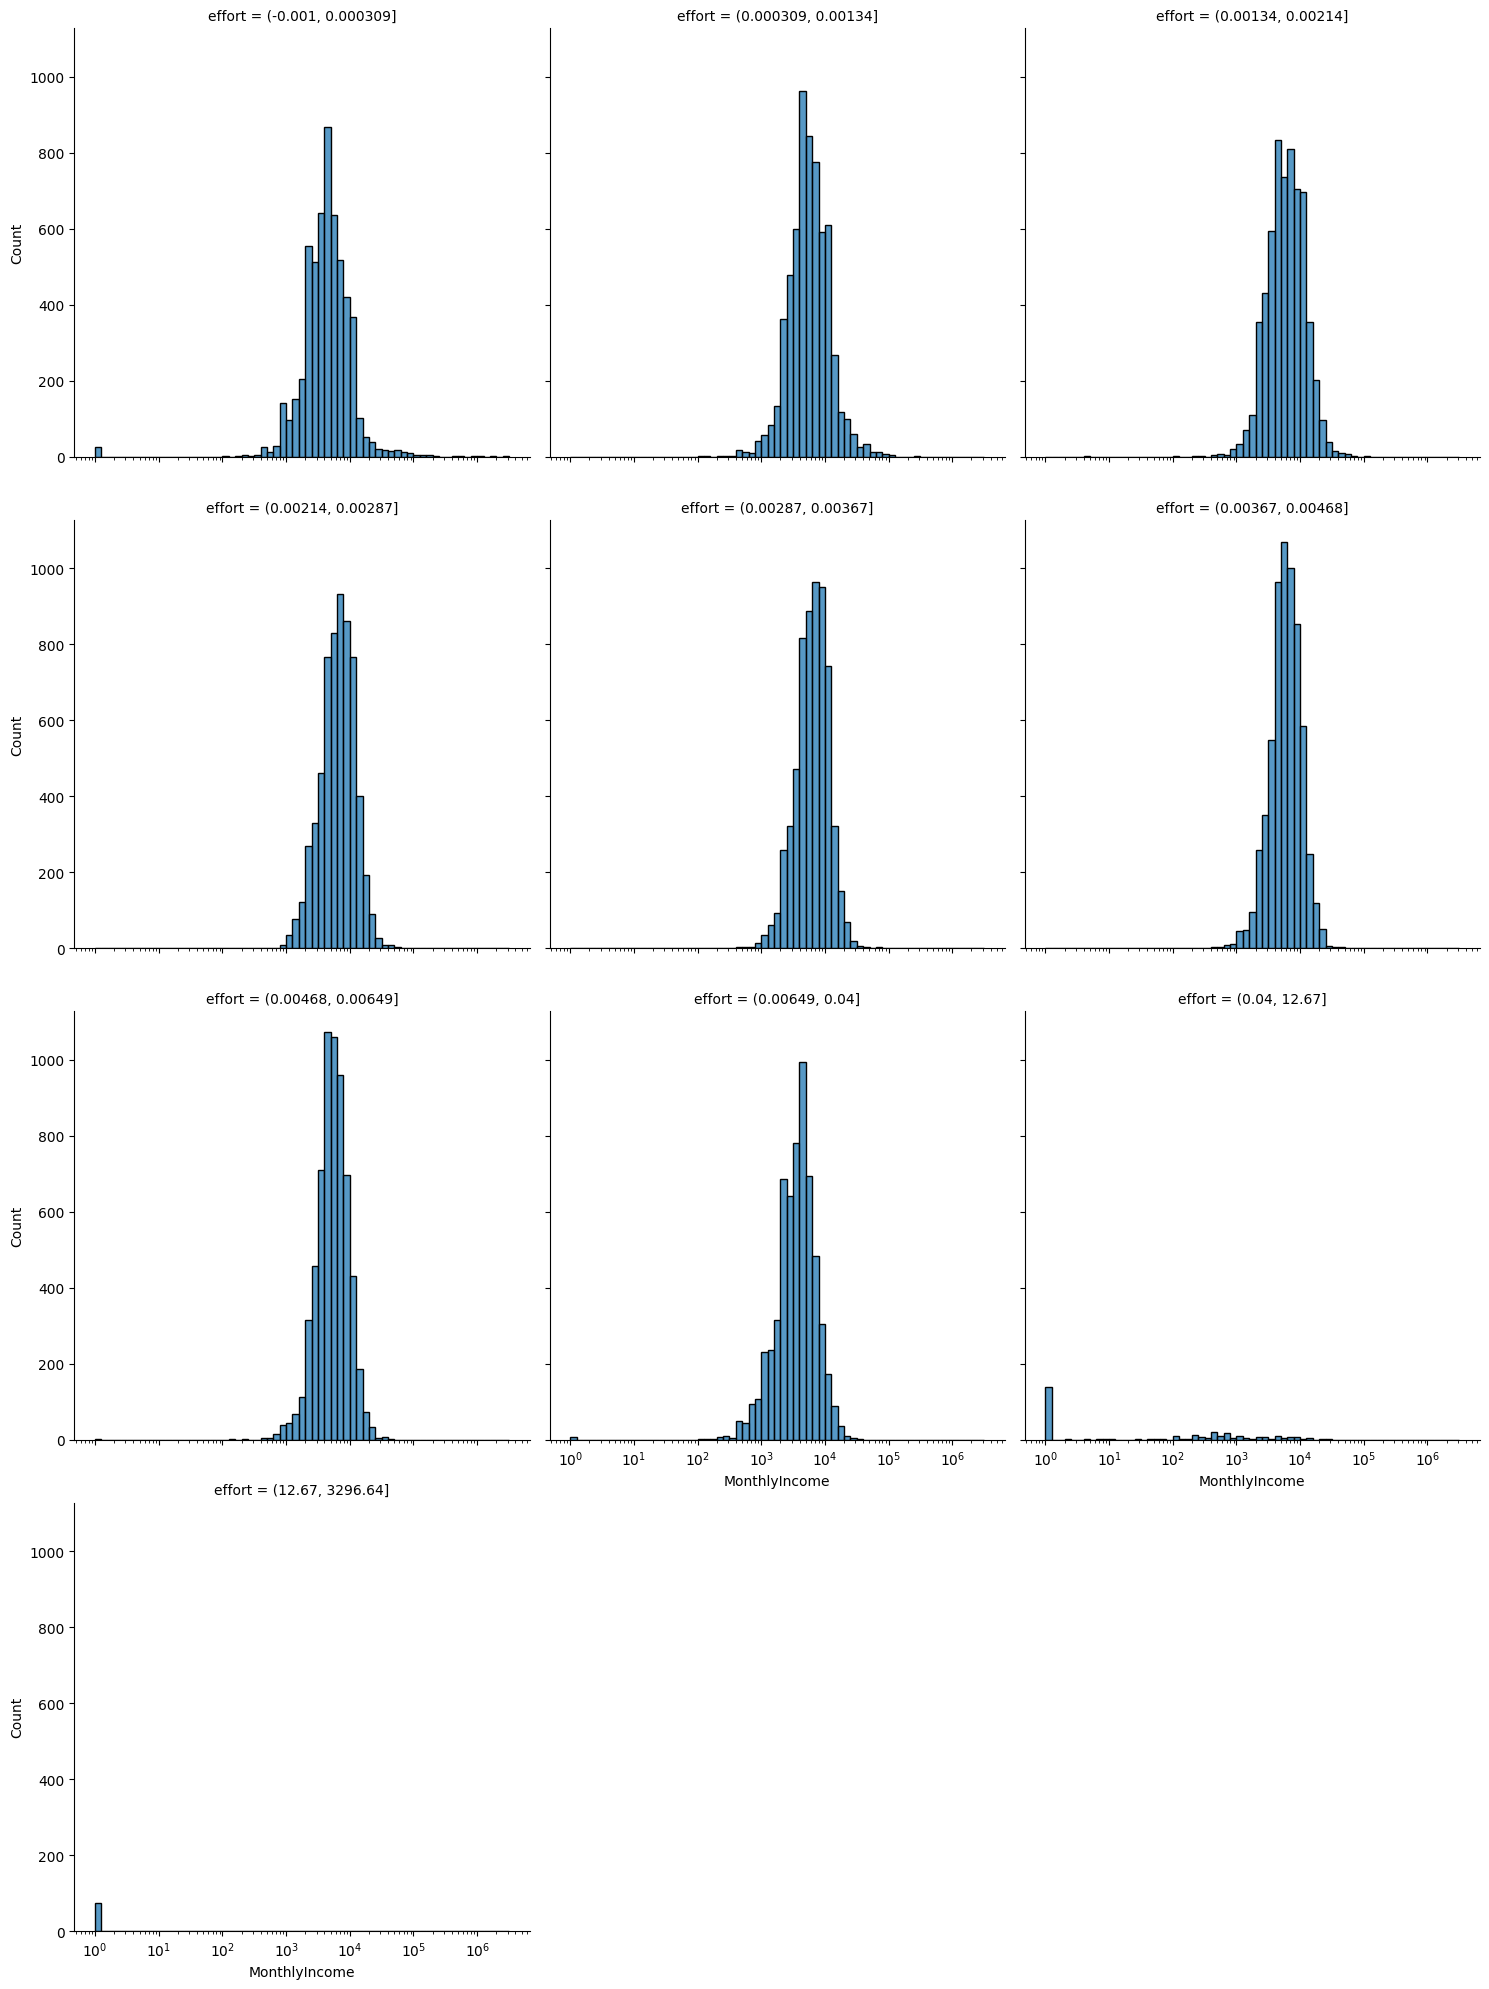

In [14]:

sns.displot(data =original_data[original_data['MonthlyIncome'] != 0], x = 'MonthlyIncome', col = 'effort', col_wrap = 3, log_scale=True, binwidth = 0.1)

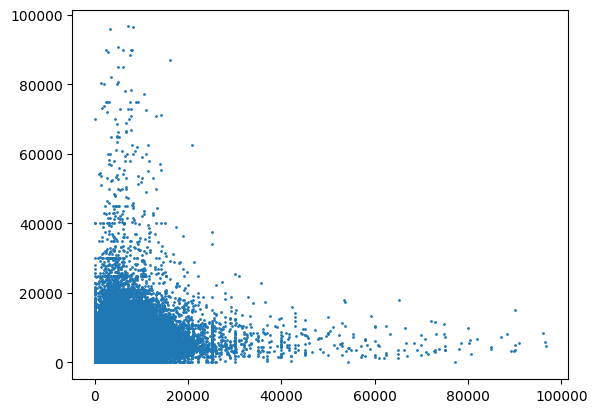

In [15]:
x = original_data['MonthlyIncome']
x = x[x < 100000]
y = x.shift(1)
plt.scatter(x, y, s = 1)

In the scatter plot above apears to be some lines. 
Samples are not independent from each other. (line at 40000, 30000)

<Axes: xlabel='MonthlyIncome', ylabel='Count'>

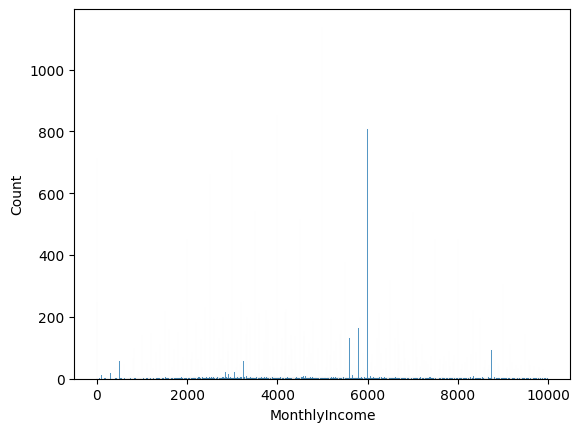

In [16]:
sns.histplot(x = x[x<10000], bins = 10000)

<Axes: xlabel='MonthlyIncome', ylabel='Count'>

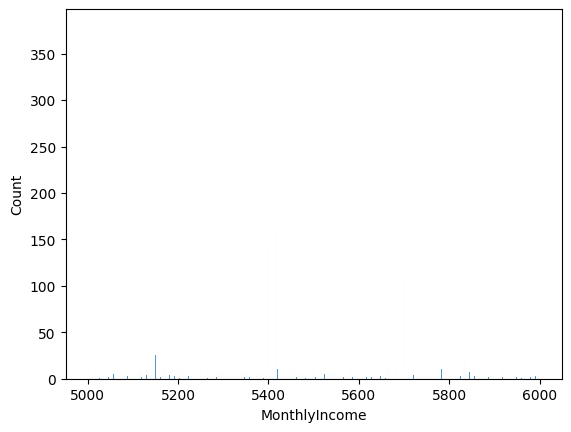

In [17]:
sns.histplot(x = x[(x>5000) & (x<6000)], bins = 10000)

Graphs above show that some incomes are more favourable than other ones therefore this does not seem to be truly continues.

### Summary of observations:

- Categories are ordinal.
- There are some outlier.
- Each category has a different non-gaussian distribution (skewed).
- There are some categories with zeroes and ones.
- Data is imbalanced.
- Samaples seem to be not independent from each other.


I have chosen WGAN as the generative model for this task as it aims to learn the underlying data distribution and complexity that exist in the data using deep learning. Statistical models often make certain assumptions about the underlying data distribution or rely on simplified assumption about the relationship between variables. These assumptions may not capture the full complicity and dependencies present in the tabular data. In contrast GANs learn the data distribution directly from the data, allowing them to capture complex patterns and dependencies more effectively however they are very unstable and very sensitive to tuning.

The architecture is a GAN (Generative Adversarial Network) model designed for generating synthetic tabular data that includes continuous and ordinal features. Breaking down the architecture step by step:


### Generator:

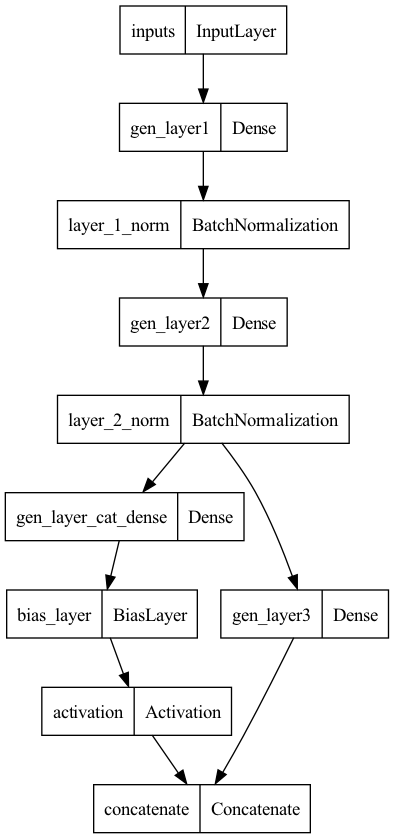

The `define_generator` function defines the generator model that takes random noise as input and generates fake data samples. The key components are:

- Input Layer: The generator takes input in the form of random noise with shape `self.noise_dimensions`.
- Dense Layers: Two dense layers with LeakyReLU activation functions are used to process the input noise. The first dense layer has 15 units, and the second dense layer has 30 units

- The LeakyReLU activation function is chosen to mitigate the vanishing gradient problem, capture complex decision boundaries, and prevent dead neurons.

- Batch Normalization: Batch normalization layers is applied after each dense layer to normalize the activations and improve the stability and performance of the model.

- Output Layers: The generator has two output layers. The first output layer (`gen_layer3`) has a single unit with a sigmoid activation function, which produces continuous output values between 0 and 1. The second output layer (`gen_layer_cat_activate`) has a linear activation function and produces the output for the ordinal feature. It is passed through a bias layer (`BiasLayer`) and then activated using a sigmoid activation function.

Combination of bias single node and activation function constrains the output to match the ordinal encoding. We want there to be zeroes and ones hence we use sigmoid as the activation layer. The single node forces the entire state to be a single number. Bias layer causes the output to be partitioned in to distinct ranges, where the system is learning the optimal placement of boundaries.


- Concatenation: The outputs from the two output layers are concatenated using the `Concatenate` layer to obtain the final generator output.


### Discriminator:
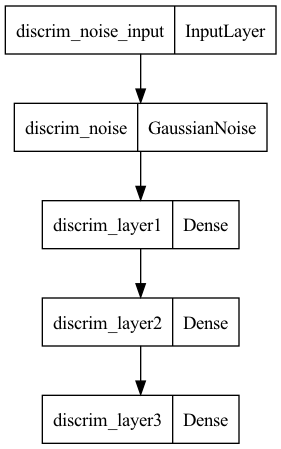
The `define_discriminator` function defines the discriminator model, which aims to classify examples as real (from the original dataset) or fake (generated by the generator). Here are the key components:

•	Dense Layers: The discriminator has two dense layers with LeakyReLU activation functions. The first dense layer has 25 units, and the second dense layer has 50 units. These layers process the input data, which includes both continuous and ordinal features.

•	Output Layer: The discriminator has a single-unit output layer with a linear activation function (`activation='linear'`). It outputs a continuous value, which can be interpreted as the discriminator's confidence score for the input sample being real or fake.

•	The Wasserstein loss is used for discriminator, to reduce the instability problems in GANs. By minimizing the Wasserstein loss, the generator can learn to generate samples that gradually approach the distribution of real data. The Wasserstein loss measures the discrepancy between the probability distributions of real and fake data generated by the GAN. It provides a more stable and meaningful training signal compared to other loss functions like binary cross-entropy. The loss is typically defined as the difference between the average discriminator output for real samples and the average discriminator output for fake samples. 


### GAN:
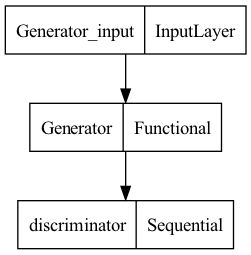

The `define_gan` function creates the GAN model by combining the generator and discriminator. The discriminator's weights are set as non-trainable in this model. Here are the key components:

•	Sequential Model: The GAN model is created as a sequential model.
•	Generator and Discriminator: The generator and discriminator models are added as sequential layers to the GAN model in that order.
•	Compilation: The GAN model is compiled with the binary cross-entropy loss function (`loss='binary_crossentropy'`) and an optimizer (`optimizer=Adam`) with specific learning rate (`learning_rate=0.0001`) and beta parameters.

The overall GAN architecture follows the typical setup of a generator model that generates fake data samples and a discriminator model that tries to distinguish between real and fake data samples. The GAN model combines these two models to optimize their performance iteratively during the training process.


### Pre-processing

The categorical data is ordinal, this has been taken into consideration both in the pre-processing step and in the neural network architecture of the generator.
The "effort" column is pre-processed using to_ordinal, which encodes ordinals using one-hot encoding like this:

cat 1 = \[ 0 0 0 \]

cat 2 = \[ 1 0 0 \]

cat 3 = \[ 1 1 0 \]

cat 4 = \[ 1 1 1 \]

‘MonthlyIncome’ feature is scaled using QuantileTransformer to transform the continues feature to have normal distribution. 

Sprinkling, zeros and ones:
As the distribution of zeros and ones in the data set was very different to the rest of the data I decided to train the neural networks and the WGAN on the data without zeros and ones.
After training the data without zeros and ones, the probability of occurrence of zeros and ones in each category is calculated and they are added after the synthetic data is generated.
One could also use a machine learning model to predict the occurrence of zeros and ones.


### What is preserved?
Using this implementation, I have tried to preserve the underlying relationship in the data and the distribution of the whole data. I have taken into consideration the zeros and ones. I have taken into consideration the ordinal nature of the categorical features. Categorical features are imbalanced, and I tried to take that into consideration using class weight.

WGANS are very unstable and need time and hyperparameter tuning in order to have better performance and better output synthetic data. 

### Evaluation

Generating synthetic data has an important challenge in being sure that new data is close to original data. There are several statistical tests to find out if two samples belong to the same probability distribution. 
The Student’s t-test, the Wilcoxon signed-rank test, and the Kolmogorov-Smirnov test for numerical features.

These tests compare the probability distributions of each feature in the input dataset and the synthetic data one to one.
each one of these statistical tests have some assumptions which must be met.

These assumptions make applying these tests to common datasets difficult when some features may conflict with the hypotheses while others don’t. 

If the data contains a combination of distinct types of features with different probability distributions, a single test is not valid for all of them at the same time. Some tests expect the data to follow a normal distribution, while we can have data with features of almost any distribution. 

Student’s t-test is a test comparing means. The Student’s t test relies on the assumption of normality.

The Kolmogorov-Smirnov Goodness-of-Fit Test is used to decide if a sample comes from a population with a specific distribution. In this case the categorical feature is ordinal and continuous but discretised we can still use this measure.

The Maximum Mean Discrepancy (MMD) is a measure of the discrepancy between two probability distributions. MMD provides a way to compare two distributions without explicitly estimating their densities.

In the evaluation function I have included MMD for 1000 samples and Kolmogorov-Smirnov test.

the evaluation function could be extended further by adding machine learning model to distinguish between real and synthetic instances. We could shuffle both datasets together with flags indicating whether the data is real or synthetic. Then train a ML model that tries to predict this flag. The easier it is to predict the flag, the more distinguishable between real and synthetic data. To do this we could use XGBoost or Logistic Regression as the detectors.


### Next steps:


- WGAN-GP (Wasserstein GAN with gradient penalty),WGAN-GP, an additional gradient penalty term to improve training stability. I use the Wasserstein loss to addresses some of the limitations of traditional GANs in order and provides a more stable training signal.

- Class weight, using the `class_weight` parameter in `train_on_batch`, one can give more emphasis to certain samples, such as the minority class samples in the imbalanced dataset. This will be the way to deal with the imbalanced data set to the impact of each sample on the model's parameter updates and ultimately influence the learning process.

- Hyperparameter tuning can play a crucial role in improving the output of this model, finding the optimal configuration for various parameters, such as:

     - learning Rate
     - Batch size
     - number of Generator and Discriminator Updates: In WGAN, the generator and discriminator are typically updated alternately for a certain number of steps. Finding the optimal number of updates for each can impact the quality of the generated samples. Increasing the number of discriminator updates relative to the generator updates can lead to more stable training and better convergence.
     - Regularization Parameters: WGAN-GP introduces a regularization term (gradient penalty). The weight or coefficient assigned to this penalty term can be tuned to control the impact of the penalty on the overall loss function. 
     - Model Architecture: The architecture of the generator and discriminator networks can affect the performance, tuning the number of layers, layer sizes.
- CTGAN is designed specifically for generating synthetic tabular data. It leverages a GAN architecture and applies conditional generation to capture the conditional dependencies among different features in the tabular dataset.
- In the solusion that I have implimneted, I apply QuantileTransformer to the whole data set, one could try applying QuantileTransformer to incomes for each category and see how that performs.

 - The evaluation function could be extended further by adding machine learning model to distinguish between real and synthetic instances. We could shuffle both datasets together with flags indicating whether the data is real or synthetic. Then train a ML model that tries to predict this flag. The easier it is to predict the flag, the more distinguishable between real and synthetic data. To do this we could use XGBoost or Logistic Regression as the detectors.


### Code generalization:

I have added a config file to show case how I would further generalize this code for datasets with more than two columns. I did not generalize that in this piece of code as in this stage it would have compromised the clarity in the code. The input data columns could be divided to Ordinal, categorical and numerical features and treated the same in a loop. They could be provided as a list in the config file and further generalize the code.